In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [51]:
%load_ext autoreload


from pta_replicator import sim as ptrsim
from pta_replicator import spharmORFbasis as ptrspharm
import libstempo.plot as LP, libstempo.toasim as LT

import astropy
from astropy import units as u, constants as c
from pint import pulsar_mjd
from pint import simulation as psim
from astropy.time import Time
from pint import toa
import pint
from enterprise.pulsar import Pulsar
from enterprise.signals import (gp_signals, parameter, signal_base, utils,
                                white_signals)

from enterprise_extensions import blocks as ee_blocks
from enterprise.signals import utils 
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import copy

import ephem

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
from enterprise_extensions import sampler as ee_sampler
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc
import os
import la_forge
from la_forge.diagnostics import plot_chains
from la_forge.core import Core
import json

Optional mpi4py package is not installed.  MPI support is not available.
Optional acor package is not installed. Acor is optionally used to calculate the effective chain length for output in the chain file.


In [13]:
from loguru import logger
pint.logging.setup(sink=sys.stderr, level="WARNING", usecolors=True)

2

WARNING  (pint.logging                  ): /home/nima/anaconda3/envs/ent15yr_new/lib/python3.9/site-packages/pint/models/timing_model.py:398 UserWarning: PINT only supports 'T2CMETHOD IAU2000B'
WARNING  (pint.logging                  ): /home/nima/anaconda3/envs/ent15yr_new/lib/python3.9/site-packages/pint/models/model_builder.py:198 UserWarning: Unrecognized parfile line 'EPHVER 5'
WARNING  (pint.logging                  ): /home/nima/anaconda3/envs/ent15yr_new/lib/python3.9/site-packages/pint/models/timing_model.py:398 UserWarning: PINT only supports 'T2CMETHOD IAU2000B'
WARNING  (pint.logging                  ): /home/nima/anaconda3/envs/ent15yr_new/lib/python3.9/site-packages/pint/models/model_builder.py:198 UserWarning: Unrecognized parfile line 'EPHVER 5'
WARNING  (pint.logging                  ): /home/nima/anaconda3/envs/ent15yr_new/lib/python3.9/site-packages/pint/models/timing_model.py:398 UserWarning: PINT only supports 'T2CMETHOD IAU2000B'
WARNING  (pint.logging            

In [14]:
# let's grab all of the parfiles from 12p5 dataset and pick out the 4 simulation pulsars

par_dir = '/home/nima/nanograv/bwm_fpfe/12.5yr_blankresids/NANOparfiles/'
psrnames = []
for fname in sorted(os.listdir(par_dir))[0:4]:
    psrnames.append(fname.strip('.par'))
print(psrnames)

['B1855+09', 'B1937+21', 'B1953+29', 'J0023+0923']


In [ ]:
# Make base fakepar/faketim files for these 
# outdir_top = '/home/nima/nanograv/bwm_fpfe/ptrsim_datasets/'

# for psrname in psrnames:
#     fakepar = par_dir + '{}.par'.format(psrname)
#     fake_obstimes = np.arange(53000, 53000 + 365.25*12, 30)
#     fakepsr = LT.fakepulsar(fakepar, obstimes = fake_obstimes, toaerr=0.2)

#     os.makedirs(outdir_top, exist_ok=True)
#     fakepsr.savepar(outdir_top + 'base_partim/{}_fake.par'.format(fakepsr.name))
#     fakepsr.savetim(outdir_top + 'base_partim/{}_fake.tim'.format(fakepsr.name))


In [ ]:
# ptr_simpsrs = []
# for psrname in psrnames:
#     parfile_path = outdir_top + 'base_partim/{}_fake.par'.format(psrname)
#     timfile_path = outdir_top + 'base_partim/{}_fake.tim'.format(psrname)
    
#     with open(parfile_path, 'r') as pfile:
#         with open(timfile_path, 'r') as tfile:
#             ptr_psr = ptrsim.SimulatedPulsar(pfile, tfile)
#             ptr_simpsrs.append(ptr_psr)

# Let's try to load in a parfile and make a PINT simulated pulsar

In [ ]:
super_partimdir = '/home/nima/nanograv/bwm_fpfe/ptrsim_datasets/base_partim/'
for psrname in psrnames:
    parfile = super_partimdir + '{}_fake.par'.format(psrname)
    psr_tm = pint.models.get_model(parfile)
    
    obs_times = np.arange(53000, 53000 + 365.25*12, 30)
    pint_ts = Time(obs_times, scale="utc", format="pulsar_mjd")
    fake_toas = psim.make_fake_toas_fromMJDs(pint_ts, psr_tm, error=(0.2 * u.microsecond))
    outtim = super_partimdir + '{}_fake.tim'.format(psrname)
    fake_toas.write_TOA_file(outtim)

In [22]:
def plot_resids(ptr_psr):
#     toas = np.array(ptr_psr.toas.table['tdbld'], dtype='float64')
#     resids = np.array(ptr_psr.rs.resids, dtype='float64')
#     errors = np.array(ptr_psr.toas.table['error'], dtype='float64')
    
    toas = ptr_psr.toas.table['tdbld']
#     resids = [(q.to('s')).value for q in ptr_psr.rs.resids] # the resids are stored as quantities
    resids = ptr_psr.rs.resids.to('s')
    errors = ptr_psr.toas.table['error'].quantity.to('s')

    
    print(type(resids[0]))
    print(type(toas[0]))
    print(type(errors[0]))
    
    fig, ax = plt.subplots(figsize = (10,10))
    ax.scatter(toas, resids)
    ax.errorbar(toas, resids, yerr=errors, fmt='o')
    ax.set_title("PSR {} residuals".format(ptr_psr.name))
    plt.show()

In [ ]:
ptr_simpsrs = []
for psrname in psrnames:
    parfile_path = super_partimdir + '{}_fake.par'.format(psrname)
    timfile_path = super_partimdir + '{}_fake.tim'.format(psrname)
    
    with open(parfile_path, 'r') as pfile:
        with open(timfile_path, 'r') as tfile:
            ptr_psr = ptrsim.SimulatedPulsar(pfile, tfile)
            ptr_simpsrs.append(ptr_psr)

In [ ]:
ptr_simpsrs[0].fit()
plot_resids(ptr_simpsrs[0])

In [ ]:
ploc = ptr_simpsrs[0].loc
if "RAJ" and "DECJ" in ploc.keys():
    ptheta = np.pi / 2 - ploc["DECJ"]
    pphi = ploc["RAJ"]
elif "ELONG" and "ELAT" in ploc.keys():
    fac = 1.0
    if "B" in ptr_simpsrs[0].name:
        epoch = "1950"
    else:
        epoch = "2000"
    coords = ephem.Equatorial(ephem.Ecliptic(str(ploc["ELONG"] * fac), str(ploc["ELAT"] * fac)), epoch=epoch)

    ptheta = np.pi / 2 - float(repr(coords.dec))
    pphi = float(repr(coords.ra))
    
bwm_phi = pphi + 0.03
bwm_theta = ptheta - 0.02
bwm_pol = -np.pi/8

In [ ]:
ptrsim.add_gw_memory(ptr_simpsrs[0], 1e-14, bwm_theta, bwm_phi, bwm_pol, 54000)
ptr_simpsrs[0].fit()

In [ ]:
plot_resids(ptr_simpsrs[0])

In [ ]:
print(ptr_simpsrs[0].toas.get_summary())

In [ ]:
ptrsim.add_efac(ptr_simpsrs[0],1)
ptr_simpsrs[0].fit()
plot_resids(ptr_simpsrs[0])

# Great! Let's make a full data set now using PTR SIM

In [15]:
super_partimdir = '/home/nima/nanograv/bwm_fpfe/ptrsim_datasets/WN_only_idealized/'
os.makedirs(super_partimdir, exist_ok=True)

base_pardir = "/home/nima/nanograv/bwm_fpfe/ptrsim_datasets/base_partim/"
nrealization = 1000
for realization in range(nrealization):
    realization_dir = super_partimdir + '{}/'.format(realization)
    os.makedirs(realization_dir, exist_ok=True)

    for psrname in psrnames:
        parfile_path = base_pardir + '{}_fake.par'.format(psrname)
        timfile_path = base_pardir + '{}_fake.tim'.format(psrname)
          
        with open(parfile_path, 'r') as pfile:
            with open(timfile_path, 'r') as tfile:
                ptr_psr = ptrsim.SimulatedPulsar(pfile, tfile)

        pint.simulation.zero_residuals(ptr_psr.toas, ptr_psr.model)
        ptrsim.add_efac(ptr_psr, 1)
        ptr_psr.fit()
        ptr_psr.write_partim(outpar = realization_dir + '{}.par'.format(psrname, realization), outtim = realization_dir + '{}.tim'.format(psrname, realization))
        
        
        

<class 'astropy.units.quantity.Quantity'>
<class 'numpy.longdouble'>
<class 'astropy.units.quantity.Quantity'>


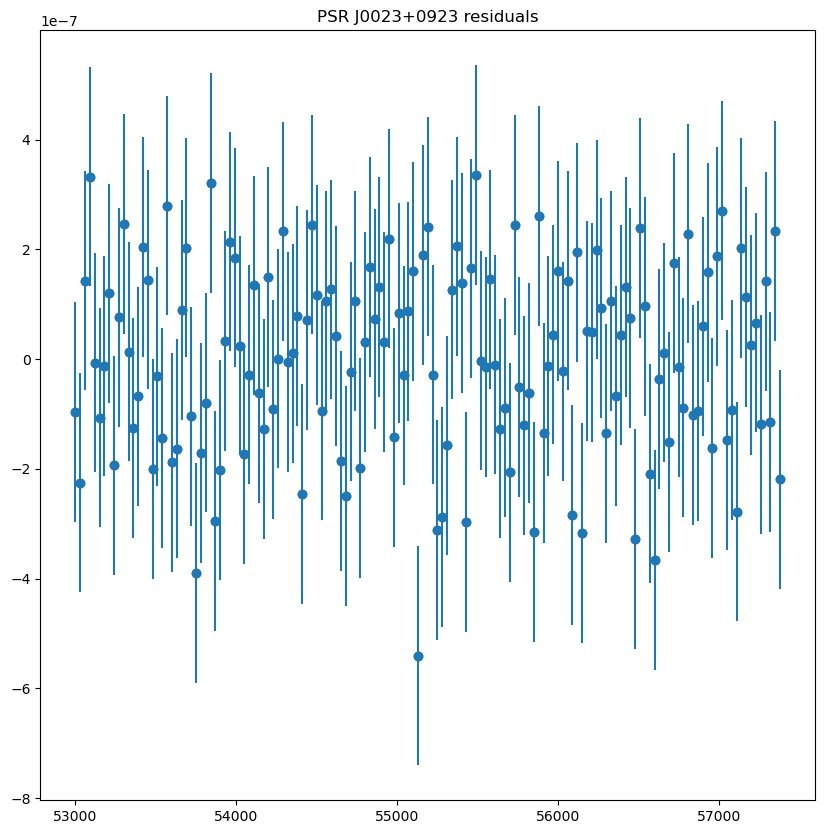

<class 'astropy.units.quantity.Quantity'>
<class 'numpy.longdouble'>
<class 'astropy.units.quantity.Quantity'>


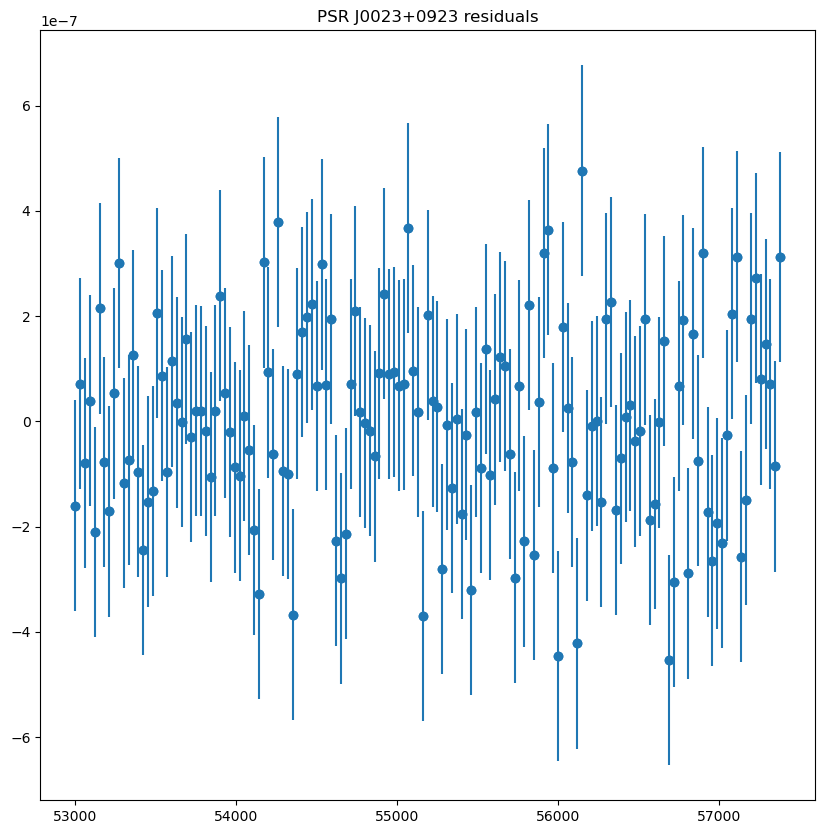

In [14]:
for i in range(1000, 1002):
    parfile_path = '/home/nima/nanograv/bwm_fpfe/ptrsim_datasets/WN_only/{}/{}.par'.format(i,psrname)
    timfile_path = '/home/nima/nanograv/bwm_fpfe/ptrsim_datasets/WN_only/{}/{}.tim'.format(i,psrname)
    
    with open(parfile_path, 'r') as pfile:
        with open(timfile_path, 'r') as tfile:
            ptr_psr = ptrsim.SimulatedPulsar(pfile, tfile)

    plot_resids(ptr_psr)

# Now let's make a data set with bwm

First just figure out the injection parameters

In [67]:
super_partimdir = '/home/nima/nanograv/bwm_fpfe/ptrsim_datasets/base_partim/'

ptr_simpsrs = []
for psrname in psrnames:
    parfile_path = super_partimdir + '{}_fake.par'.format(psrname)
    timfile_path = super_partimdir + '{}_fake.tim'.format(psrname)
    
    with open(parfile_path, 'r') as pfile:
        with open(timfile_path, 'r') as tfile:
            ptr_psr = ptrsim.SimulatedPulsar(pfile, tfile)
            ptr_simpsrs.append(ptr_psr)

In [69]:
phis = []
thetas = []
for psr in ptr_simpsrs:
    
    ploc = psr.loc
    if "RAJ" and "DECJ" in ploc.keys():
        ptheta = np.pi / 2 - ploc["DECJ"]
        pphi = ploc["RAJ"]
    elif "ELONG" and "ELAT" in ploc.keys():
        fac = 1.0
        if "B" in psr.name:
            epoch = "1950"
        else:
            epoch = "2000"
        coords = ephem.Equatorial(ephem.Ecliptic(str(ploc["ELONG"] * fac), str(ploc["ELAT"] * fac)), epoch=epoch)
    
        thetas.append(np.pi / 2 - float(repr(coords.dec)))
        phis.append(float(repr(coords.ra)))
    
bwm_phi = np.mean(phis)
bwm_theta = np.mean(thetas)
bwm_pol = np.pi/8
bwm_t0_mjd = 55000

In [70]:
print(bwm_phi, bwm_theta)

3.8500175050886978 1.2674466820109203


In [71]:
super_partimdir = '/home/nima/nanograv/bwm_fpfe/ptrsim_datasets/WN_BWM_idealized/'
os.makedirs(super_partimdir, exist_ok=True)

base_pardir = "/home/nima/nanograv/bwm_fpfe/ptrsim_datasets/base_partim/"
nrealization = 3000
for realization in range(1001, nrealization):
    realization_dir = super_partimdir + '{}/'.format(realization)
    os.makedirs(realization_dir, exist_ok=True)

    for psrname in psrnames:
        parfile_path = base_pardir + '{}_fake.par'.format(psrname)
        timfile_path = base_pardir + '{}_fake.tim'.format(psrname)
          
        with open(parfile_path, 'r') as pfile:
            with open(timfile_path, 'r') as tfile:
                ptr_psr = ptrsim.SimulatedPulsar(pfile, tfile)

        pint.simulation.zero_residuals(ptr_psr.toas, ptr_psr.model)
        ptrsim.add_gw_memory(ptr_psr, 1e-14, bwm_theta, bwm_phi, bwm_pol + np.pi/4,bwm_t0_mjd)
        # plot_resids(ptr_psr)
        ptrsim.add_efac(ptr_psr, 1)
        ptr_psr.fit()
        # plot_resids(ptr_psr)
        ptr_psr.write_partim(outpar = realization_dir + '{}.par'.format(psrname, realization), outtim = realization_dir + '{}.tim'.format(psrname, realization))
        
        
        

KeyboardInterrupt: 

<class 'astropy.units.quantity.Quantity'>
<class 'numpy.longdouble'>
<class 'astropy.units.quantity.Quantity'>


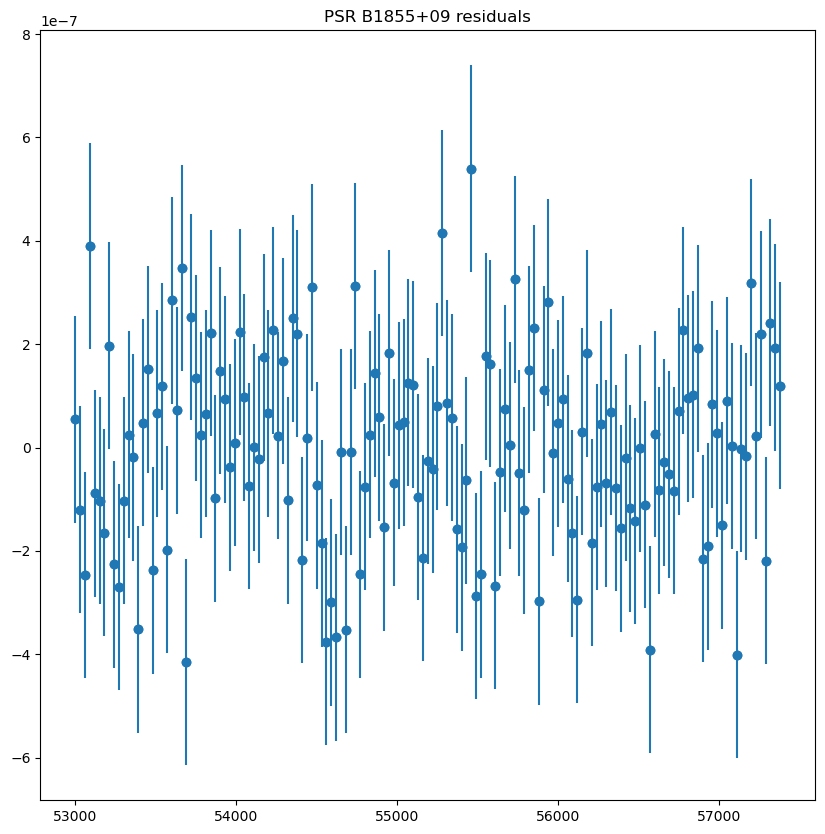

<class 'astropy.units.quantity.Quantity'>
<class 'numpy.longdouble'>
<class 'astropy.units.quantity.Quantity'>


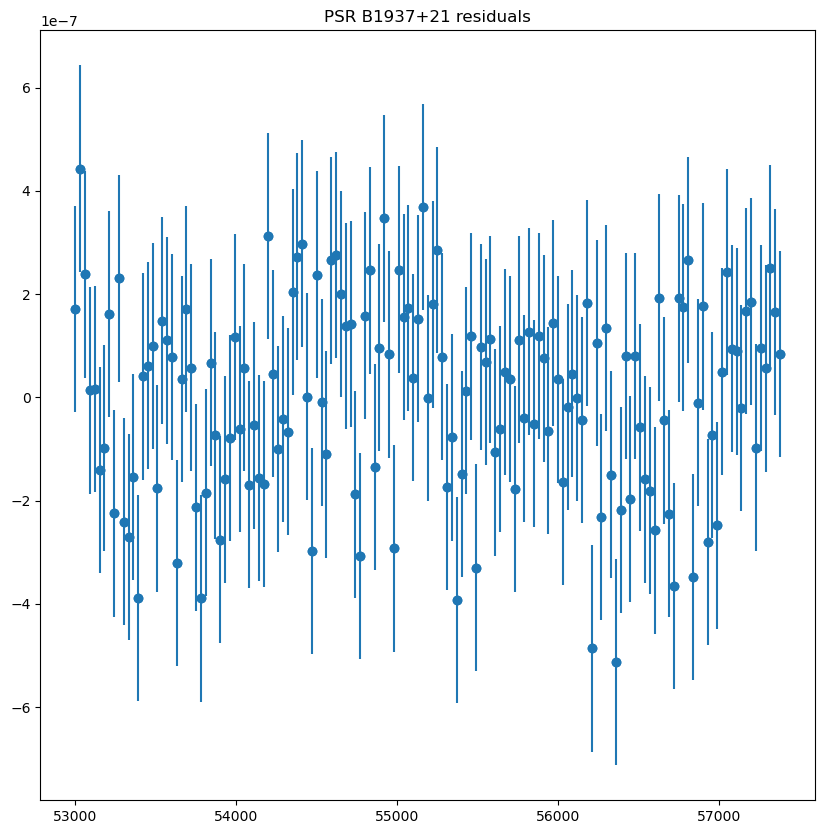

<class 'astropy.units.quantity.Quantity'>
<class 'numpy.longdouble'>
<class 'astropy.units.quantity.Quantity'>


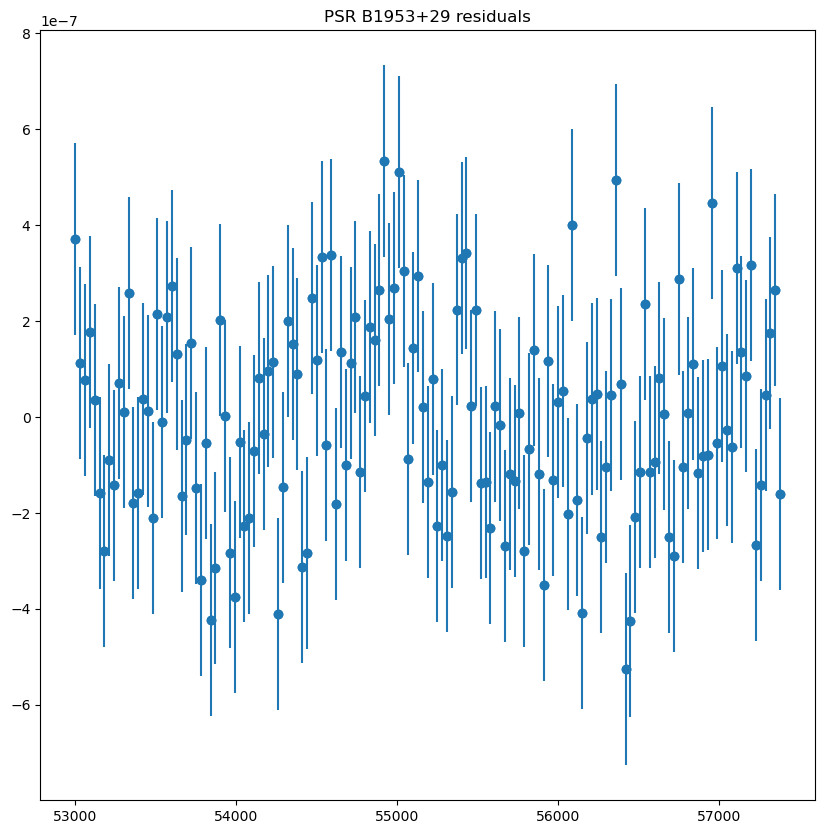

<class 'astropy.units.quantity.Quantity'>
<class 'numpy.longdouble'>
<class 'astropy.units.quantity.Quantity'>


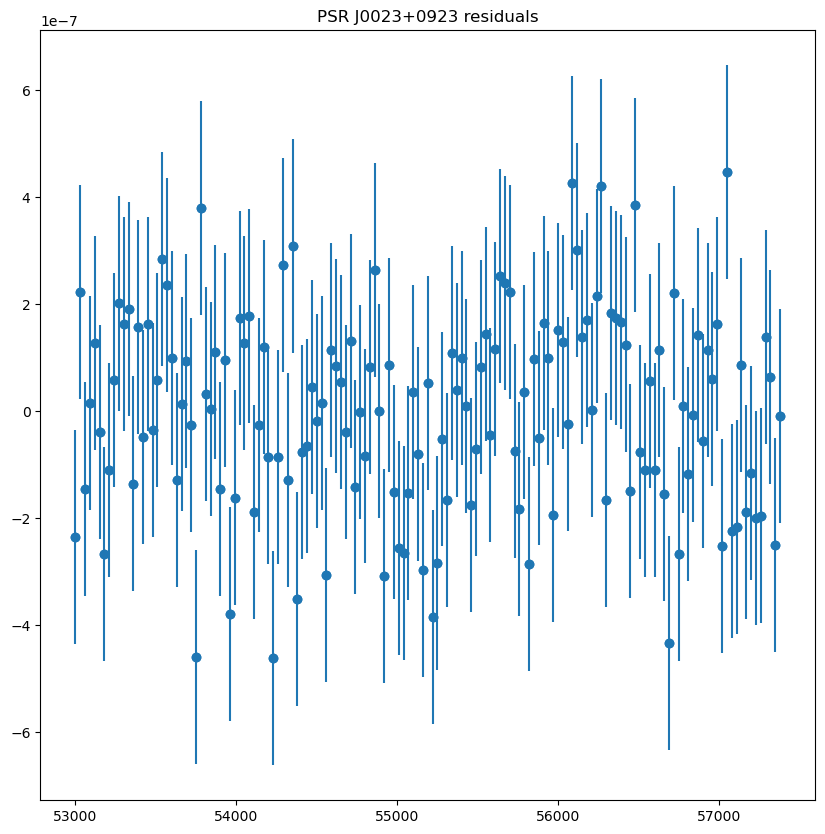

In [30]:
#take a look at the first few of these:
super_partimdir = '/home/nima/nanograv/bwm_fpfe/ptrsim_datasets/WN_BWM_idealized/0/'

for psrname in psrnames:
    parfile_path = super_partimdir + '{}.par'.format(psrname)
    timfile_path = super_partimdir + '{}.tim'.format(psrname)
      
    with open(parfile_path, 'r') as pfile:
        with open(timfile_paths(ptr_psr)

# Let's make a big injection that should be easy to find in MCMC run

In [33]:
super_partimdir = '/home/nima/nanograv/bwm_fpfe/ptrsim_datasets/base_partim/'

ptr_simpsrs = []
for psrname in psrnames:
    parfile_path = super_partimdir + '{}_fake.par'.format(psrname)
    timfile_path = super_partimdir + '{}_fake.tim'.format(psrname)
    
    with open(parfile_path, 'r') as pfile:
        with open(timfile_path, 'r') as tfile:
            ptr_psr = ptrsim.SimulatedPulsar(pfile, tfile)
            ptr_simpsrs.append(ptr_psr)

In [38]:
phis = []
thetas = []
for psr in ptr_simpsrs:
    
    ploc = psr.loc
    if "RAJ" and "DECJ" in ploc.keys():
        ptheta = np.pi / 2 - ploc["DECJ"]
        pphi = ploc["RAJ"]
    elif "ELONG" and "ELAT" in ploc.keys():
        fac = 1.0
        if "B" in psr.name:
            epoch = "1950"
        else:
            epoch = "2000"
        coords = ephem.Equatorial(ephem.Ecliptic(str(ploc["ELONG"] * fac), str(ploc["ELAT"] * fac)), epoch=epoch)
    
        thetas.append(np.pi / 2 - float(repr(coords.dec)))
        phis.append(float(repr(coords.ra)))
    
bwm_phi = np.mean(phis)
bwm_theta = np.mean(thetas)
bwm_pol = np.pi/8
bwm_t0_mjd = 55000

In [39]:
print(bwm_phi, bwm_theta)

3.8500175050886978 1.2674466820109203


In [57]:
super_partimdir = '/home/nima/nanograv/bwm_fpfe/ptrsim_datasets/WN_BWM_idealized_hugeBWM_smallWN/'
os.makedirs(super_partimdir, exist_ok=True)

base_pardir = "/home/nima/nanograv/bwm_fpfe/ptrsim_datasets/base_partim/"
nrealization = 1000
for realization in range(nrealization):
    realization_dir = super_partimdir + '{}/'.format(realization)
    os.makedirs(realization_dir, exist_ok=True)

    for psrname in psrnames:
        parfile_path = base_pardir + '{}_fake.par'.format(psrname)
        timfile_path = base_pardir + '{}_fake.tim'.format(psrname)
          
        with open(parfile_path, 'r') as pfile:
            with open(timfile_path, 'r') as tfile:
                ptr_psr = ptrsim.SimulatedPulsar(pfile, tfile)

        pint.simulation.zero_residuals(ptr_psr.toas, ptr_psr.model)
        ptrsim.add_gw_memory(ptr_psr, 1e-13, bwm_theta, bwm_phi, bwm_pol, bwm_t0_mjd)
        # plot_resids(ptr_psr)
        ptrsim.add_efac(ptr_psr, 0.2)
        ptr_psr.fit()
        # plot_resids(ptr_psr)
        ptr_psr.write_partim(outpar = realization_dir + '{}.par'.format(psrname, realization), outtim = realization_dir + '{}.tim'.format(psrname, realization))
        
        
        

## Verify the recovery

In [60]:
partim_dir = '/home/nima/nanograv/bwm_fpfe/ptrsim_datasets/WN_BWM_idealized_hugeBWM_smallWN/0/'
psrlist = ['B1855+09', 'B1937+21', 'B1953+29', 'J0023+0923']
psrs = []

for psrname in psrlist:
    pfile = partim_dir + psrname + '.par'
    tfile = partim_dir + psrname + '.tim'
    psrs.append(Pulsar(pfile,tfile))

efac = parameter.Uniform(0, 10)
# equad = parameter.Constant()
ef = white_signals.MeasurementNoise(efac=efac)
# eq = white_signals.EquadNoise(log10_equad=equad)
tm = gp_signals.TimingModel(use_svd=True)
bwm = ee_blocks.bwm_block(Tmin = 54500, Tmax = 55500, )
s =  ef + tm + bwm

model = []
for p in psrs:
    model.append(s(p))
wn_bwm_pta = signal_base.PTA(model)

In [61]:
Niter = int(1e6)
outdir = '/home/nima/nanograv/bwm_fpfe/ptrsim_datasets/WN_BWM_idealized_hugeBWM_smallWN/0/noise_run/'
os.makedirs(outdir, exist_ok = True)

sampler=ee_sampler.setup_sampler(wn_bwm_pta, outdir = outdir)
x0 = np.hstack([p.sample() for p in wn_bwm_pta.params])

np.savetxt(outdir + 'pars.txt', list(map(str, wn_bwm_pta.param_names)), fmt='%s')
np.savetxt(outdir + 'priors.txt', list(map(lambda x: str(x.__repr__()), wn_bwm_pta.params)), fmt='%s')

sampler.sample(x0, Niter, SCAMweight=30, AMweight=15, DEweight=50)

Adding BWM prior draws...

Finished 1.00 percent in 9.102446 s Acceptance rate = 0.0628889Adding DE jump with weight 50
Finished 99.90 percent in 969.923667 s Acceptance rate = 0.264696
Run Complete


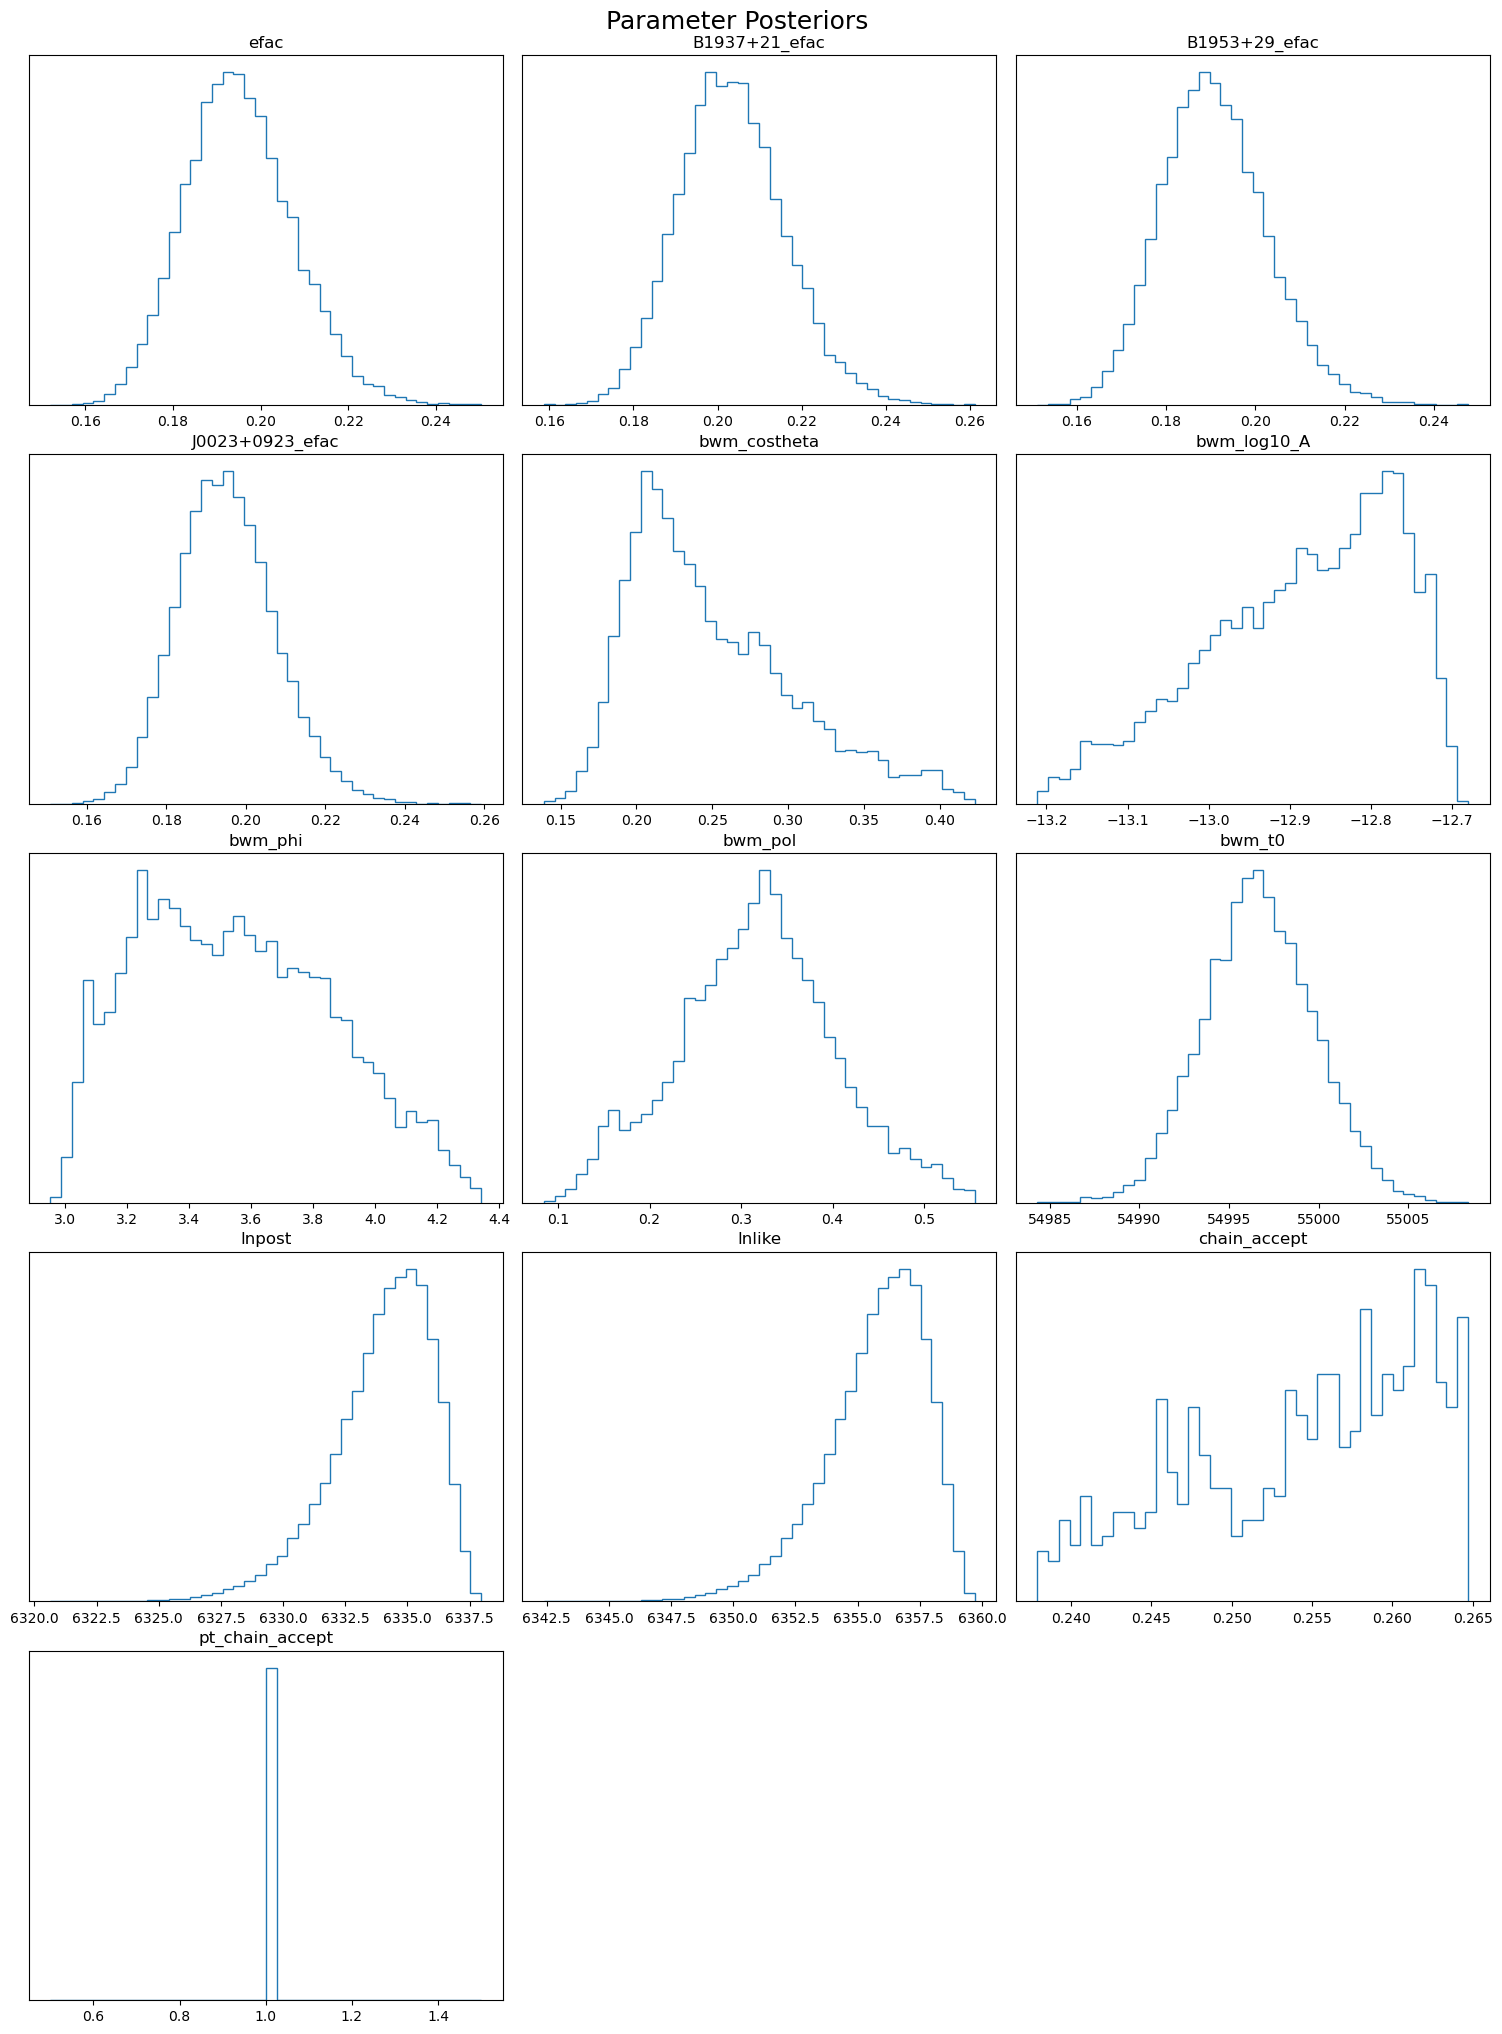

In [63]:
chaindir = '/home/nima/nanograv/bwm_fpfe/ptrsim_datasets/WN_BWM_idealized_hugeBWM_smallWN/0/noise_run/'
core = Core(chaindir=chaindir, )
plot_chains(core)

In [64]:
print(bwm_phi, bwm_theta, bwm_pol)

3.8500175050886978 1.2674466820109203 0.39269908169872414


In [65]:
def make_noise_files(psrname, chain, pars, outdir):
    x = {}
    for ct, par in enumerate(pars):
        x[par] = np.median(chain[:, ct])
    os.system('mkdir -p {}'.format(outdir))
    with open(outdir + '/{}_noise.json'.format(psrname), 'w') as fout:
        json.dump(x, fout, sort_keys=True, indent=4, separators=(',', ': '))
        
def make_noise_dict(psrlist, dir_path, outdir):
    x = {}
    for psrname in psrlist: 
        pars = np.loadtxt(dir_path+'/pars.txt', dtype=np.unicode_)
        chain = np.loadtxt(dir_path+'/chain_1.txt')
        burn = int(0.35 * len(chain))
        for ct, par in enumerate(pars):
            x[par] = np.median(chain[burn:, ct])
        with open(outdir + '/noisedict.json', 'w') as fout:
            json.dump(x, fout, sort_keys=True, indent=4, separators=(',',':'))
        make_noise_files(psrname, chain[burn:,:-4], pars, outdir=outdir)

In [59]:
print(psrnames)

['B1855+09', 'B1937+21', 'B1953+29', 'J0023+0923']


In [66]:
make_noise_dict(psrnames, dir_path = chaindir, outdir = chaindir)

# Parallelizing simulations

In [72]:
super_partimdir = '/home/nima/nanograv/bwm_fpfe/ptrsim_datasets/base_partim/'

ptr_simpsrs = []
for psrname in psrnames:
    parfile_path = super_partimdir + '{}_fake.par'.format(psrname)
    timfile_path = super_partimdir + '{}_fake.tim'.format(psrname)
    
    with open(parfile_path, 'r') as pfile:
        with open(timfile_path, 'r') as tfile:
            ptr_psr = ptrsim.SimulatedPulsar(pfile, tfile)
            ptr_simpsrs.append(ptr_psr)

In [73]:
phis = []
thetas = []
for psr in ptr_simpsrs:
    
    ploc = psr.loc
    if "RAJ" and "DECJ" in ploc.keys():
        ptheta = np.pi / 2 - ploc["DECJ"]
        pphi = ploc["RAJ"]
    elif "ELONG" and "ELAT" in ploc.keys():
        fac = 1.0
        if "B" in psr.name:
            epoch = "1950"
        else:
            epoch = "2000"
        coords = ephem.Equatorial(ephem.Ecliptic(str(ploc["ELONG"] * fac), str(ploc["ELAT"] * fac)), epoch=epoch)
    
        thetas.append(np.pi / 2 - float(repr(coords.dec)))
        phis.append(float(repr(coords.ra)))
    
bwm_phi = np.mean(phis)
bwm_theta = np.mean(thetas)
bwm_pol = np.pi/8
bwm_t0_mjd = 55000

In [82]:
def simulate_worker(realization):
    super_partimdir = '/home/nima/nanograv/bwm_fpfe/ptrsim_datasets/WN_BWM_idealized/'
    base_pardir = '/home/nima/nanograv/bwm_fpfe/ptrsim_datasets/base_partim/'
    
    realization_dir = super_partimdir + '{}/'.format(realization)
    os.makedirs(realization_dir, exist_ok=True)

    for psrname in psrnames:
        parfile_path = base_pardir + '{}_fake.par'.format(psrname)
        timfile_path = base_pardir + '{}_fake.tim'.format(psrname)
          
        with open(parfile_path, 'r') as pfile:
            with open(timfile_path, 'r') as tfile:
                ptr_psr = ptrsim.SimulatedPulsar(pfile, tfile)
                
        pint.simulation.zero_residuals(ptr_psr.toas, ptr_psr.model)
        ptrsim.add_gw_memory(ptr_psr, 1e-14, bwm_theta, bwm_phi, bwm_pol, bwm_t0_mjd)
        # plot_resids(ptr_psr)
        ptrsim.add_efac(ptr_psr, 1)
        ptr_psr.fit()
        # plot_resids(ptr_psr)
        ptr_psr.write_partim(outpar = realization_dir + '{}.par'.format(psrname, realization), outtim = realization_dir + '{}.tim'.format(psrname, realization))



In [ ]:
import multiprocessing as mp

pool = mp.Pool(processes = 8)
args = np.arange(1006, 3000)
pool.map(simulate_worker, args)

# Scratch

In [ ]:
test1855 = ptr_simpsrs[0]
ts = test1855.toas

In [ ]:
type(ts.table['error'].quantity)
print(ts.table['error'].quantity.to('s'))

In [ ]:
test1855.rs.resids.to('s')